## Automated click audio labeling

In [151]:
# all libraries used in this notebook

import os.path
from pathlib import Path
import re
import librosa
import math
import numpy as np
import matplotlib.pyplot as plt

Important: this nootbook is for atomated labeling of audio files, where click events can be unambigously detected based on maximal amplitude values

### Directory structure
Audio file datasets are located in the same folder as the current jupyter notebook, in the subfolder "01_audioDatasets/..."
-> the "01_audioDatasets" folder is excluded from git push

|- 01_Electrical_Connector_Click-Event_Detection_git_repo <br>
|----- 01_Data <br>
|---------- 01_audioDatasets <br>
|--------------- 01_ethernet_without_additional_noise <br>
|--------------- 02_ethernet_with_additional_noise <br>
|---------- clickDatasetPreprocessing.ipynb (current notebook)<br>


In case of new dataset --> new folder in 01_Data/01_audioDatasets

### 1. Read in audio files and plot wave form and mel-spectrogram

In [152]:
# sorting function for files and directories

def sort_key_func(file_name):
        numbers = re.findall(r'\d+', file_name)
        if numbers:
            return int(numbers[0])
        return file_name

In [153]:
# list current audio file datasets

cwd = str(Path.cwd())
audio_datasets_main_dir_name = "01_audioDatasets"
audio_datasets_main_dir = os.path.join(cwd, audio_datasets_main_dir_name)
audio_datasets = []

if os.path.exists(audio_datasets_main_dir):
    for i in os.listdir(audio_datasets_main_dir):
        #if folder name does not start with a dot
        if i[0] != ".": 
            audio_datasets.append(i)
    audio_datasets.sort(key=sort_key_func)
else:
    print("Audio dataset directory does not exist")

print(audio_datasets)

['01_ethernet_without_additional_noise', '02_ethernet_with_additional_noise']


In [154]:
# select dataset

dataset_num = 0

In [155]:
# add audio files from selected dataset to list

audio_dataset_dir = os.path.join(cwd, audio_datasets_main_dir_name) + "/" + audio_datasets[dataset_num]
#print(audio_dataset_dir)
#os.listdir(audio_dataset_dir)
audio_files = [f for f in os.listdir(audio_dataset_dir) if f.endswith('.m4a')]
audio_files_sorted = sorted(audio_files, key=sort_key_func)
print(f"dataset length: {len(audio_files_sorted)}")
i = 0
print("First 5 files:")
while i < 5:
    print(audio_files_sorted[i])
    i += 1


dataset length: 60
First 5 files:
New Recording 1.m4a
New Recording 2.m4a
New Recording 3.m4a
New Recording 4.m4a
New Recording 5.m4a


In [156]:
# function to calculat n_fft

def next_power_of_2(x):
        next_power_of_two = 2**(math.ceil(math.log(x, 2)))

        if next_power_of_two == x:
            next_power_of_two = next_power_of_two*2

        return next_power_of_two

In [168]:
# convert spectrogram to dB scale

## Here is something wrong with the decibel conversion, needs to be updated!!!

def power_to_db(S_mel, amin, dB_ref, top_dB_abs):
    
        
        """S_dB = 10 * np.log10(np.maximum(S_mel, amin)) 
        S_dB_clipped = np.maximum(S_dB, S_dB.max() - top_db)"""

        top_dB = -top_dB_abs
        S_dB = 10.0 * np.log10(np.maximum(amin, S_mel))
        S_dB -= 10.0 * np.log10(np.maximum(amin, dB_ref))

        #S_dB_clipped = np.maximum(S_dB, top_dB)

        return S_dB

In [169]:
# constant values used in real-time detection as well
sampling_rate = 16000 # downsampled
resolution = 0.016 # in seconds
hop_length = int(resolution * sampling_rate)
n_fft =  next_power_of_2(hop_length)
n_mels = 128 # number of mel bands
dB_ref = 1 # reference value for dB conversion, log(1) = 0
amin = 1e-12 # to avoid log(0)
top_dB_abs = 120 # maximum dB value -> 10*log(amin) = -120

In [170]:
# calculate dB mel spectrogram

def mel_spectrogram(audio_file_path, sampling_rate, n_fft, hop_length, n_mels, amin, dB_ref, top_dB_abs):
    
    signal, sampling_rate = librosa.load(audio_file_path, sr=sampling_rate)

    n_samples = len(signal)
    duration = n_samples / sampling_rate
    time = np.linspace(0, duration, n_samples)

    signal_stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, win_length=n_fft)
    S = np.abs(signal_stft) ** 2
    #print(f"s min max: {S.min(), S.max()}")

    mel_filter_bank = librosa.filters.mel(sr=sampling_rate, n_fft=n_fft, n_mels=n_mels, htk=True)
    S_mel = np.dot(mel_filter_bank, S)

    #print(f"s_mel min, max: {S_mel.min(), S_mel.max()}")

    S_dB = power_to_db(S_mel, amin=amin, dB_ref=dB_ref, top_dB_abs=top_dB_abs)
    #print(type(S_dB))
          
    #print(f"S_dB_min, max: {S_dB.min(), S_dB.max()}")

    return signal, time, S_dB

In [171]:
# plot a mel spectrogram
def plot_mel_spectrogram(signal, time, S_dB):

    fig_x = 16
    fig_y = 6
    fig, axs = plt.subplots(2, 1, figsize=(fig_x, fig_y))

    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(time, signal)
    ax1.set_xlim(left=0, right=time[-1])
    #ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Amplitude')
    ax1.set_xlim(left=time[0], right=time[-1])

    ax2 = plt.subplot(2, 1, 2)
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Frequency [Hz]')
    #ax2.set_xlim(left=time[0], right=time[-1])
    ax2.axes.xaxis.set_ticklabels([]) 
    mel_spec_img = ax2.pcolormesh(np.linspace(0, signal.shape[0] / sampling_rate, S_dB.shape[1]),
                                            np.linspace(0, sampling_rate // 2, n_mels), 
                                            S_dB, shading='auto', cmap='inferno')

    #mel_spec_img.set_clim(vmin=-top_dB_abs, vmax=dB_ref)
    mel_spec_img.set_clim(vmin=-top_dB_abs, vmax=0)

    cbar_ax = fig.add_axes([0.15, -0.05, 0.7, 0.02])
    fig.colorbar(mel_spec_img, cax=cbar_ax, orientation='horizontal', format="%+2.0f dB")

    plt.show()


/var/folders/bj/7ggffpq918g65k1n35l6t6t40000gn/T/ipykernel_20727/3226534287.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file_path, sr=sampling_rate)


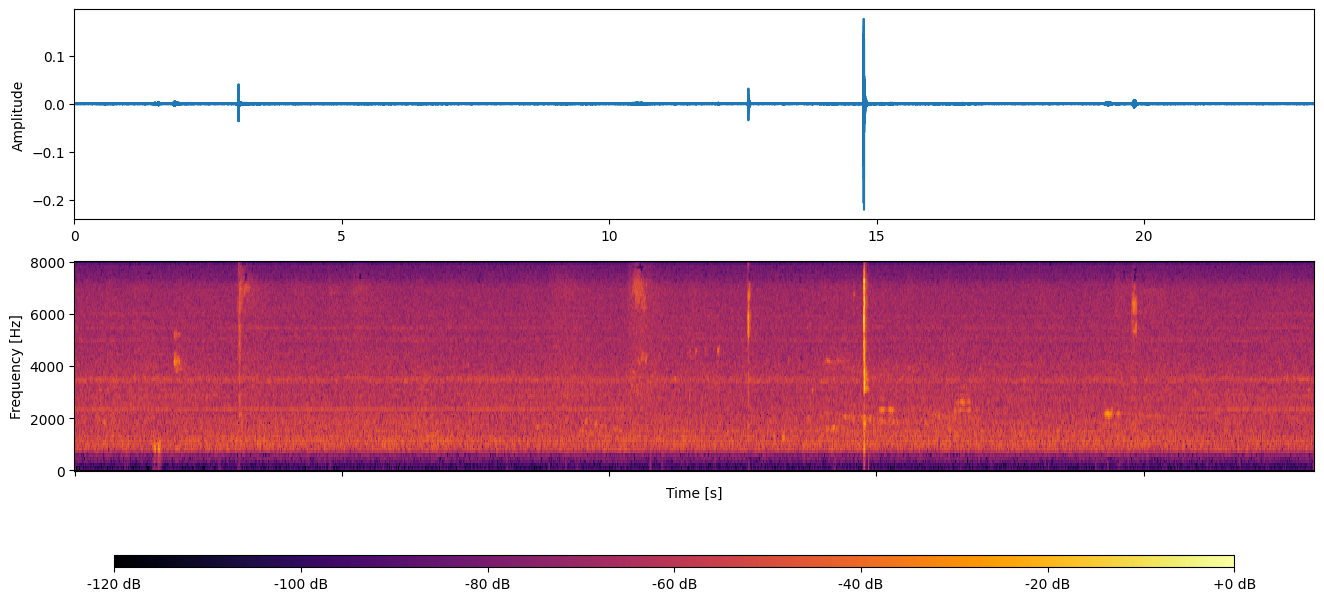

In [172]:
# plot the wave and mel spectrogram of an audio file in teh selected dataset
file_id_num = 30
if file_id_num < len(audio_files_sorted):
    audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[file_id_num])
    signal, time, S_dB = mel_spectrogram(audio_file_path, sampling_rate, n_fft, hop_length, n_mels, amin, dB_ref, top_dB_abs)
    plot_mel_spectrogram(signal, time, S_dB)
else:
    print("File ID out of range")


### 2. Automated labeling - find click peaks in the wave files
Reminder: This works only for files where click peak can be easily detected, i.e. no other noise with higher amplitude is present in the wavefrom

In [173]:
def plot_signal_interval(signal, time, peak_time, interval):
    
    plt.figure(figsize=(16, 6))
    plt.plot(time, signal)
    plt.xlim(peak_time-interval, peak_time+interval)
    
    if peak_time is not None:
        plt.axvline(x=peak_time, color='r', linestyle='--', label='Click Peak')
        plt.legend()

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Audio Signal with Click Event Peak")
    plt.tight_layout()
    plt.show()

In [174]:
time_interval = 0.512 # in seconds, this will be the window size in the real time detection as well --> 4 chunks with 2084 samples each --> with the 16 kHz sampling rate this is 0.512 seconds

# calculate peak time of the click event for each audio file in the selected dataset
def calc_peak_times(audio_files_sorted, audio_dataset_dir, sampling_rate, n_fft, hop_length, n_mels, dB_ref, top_dB_abs):
    signals = []
    signal_times = []
    peak_indices = []
    peak_times = []
    spectrograms = []

    for i in range(len(audio_files_sorted)):
        audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[i])
        signal, time, S_dB = mel_spectrogram(audio_file_path, sampling_rate, n_fft, hop_length, n_mels, amin, dB_ref, top_dB_abs)
        signals.append(signal)
        signal_times.append(time)
        spectrograms.append(S_dB)

        # search abs max value of the signal within the search interval

        search_interval_min = 5 # define search intervall based on the later plot for peak times
        search_interval_min_index = search_interval_min * sampling_rate
        search_interval_max_index = len(signal)

        j = search_interval_min_index
        peak_index = j
        while j < search_interval_max_index-1:
            if signal[j+1] > signal[peak_index]:
                peak_index = j+1
            j = j + 1
    
        #peak_index = np.argmax(np.abs(signal))
        
        peak_time = peak_index / sampling_rate
        peak_times.append(peak_time)

    return signals, signal_times, peak_indices, peak_times, spectrograms 

# get the signals, signal times and peak times for the selected dataset
signals, signal_times, peak_indices, peak_times, spectrograms  = calc_peak_times(audio_files_sorted, audio_dataset_dir, sampling_rate, n_fft, hop_length, n_mels, dB_ref, top_dB_abs)


/var/folders/bj/7ggffpq918g65k1n35l6t6t40000gn/T/ipykernel_20727/3226534287.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file_path, sr=sampling_rate)
/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


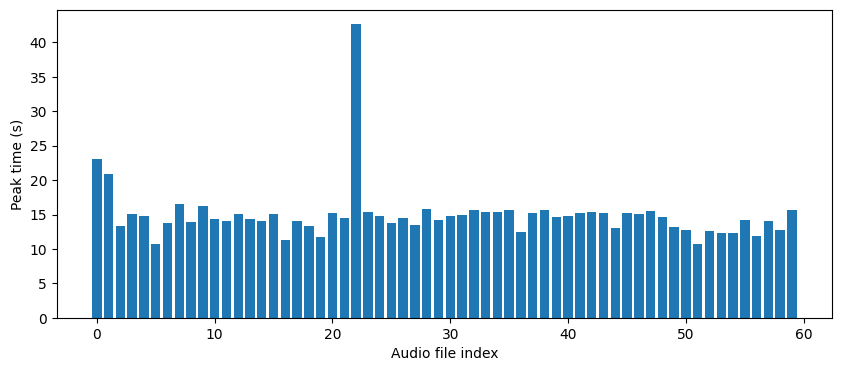

mean peak time: 14.925990625


In [175]:
# check if the peak time are around the same time for all audio files -> same robotic peg-in-hole event was recorded
# outliers should be checked

plt.figure(figsize=(10, 4))
plt.bar(range(len(peak_times)), peak_times)
plt.xlabel('Audio file index')
plt.ylabel('Peak time (s)')

plt.show()

print(f"mean peak time: {np.mean(peak_times)}")

/var/folders/bj/7ggffpq918g65k1n35l6t6t40000gn/T/ipykernel_20727/2088481195.py:5: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(peak_time-interval, peak_time+interval)


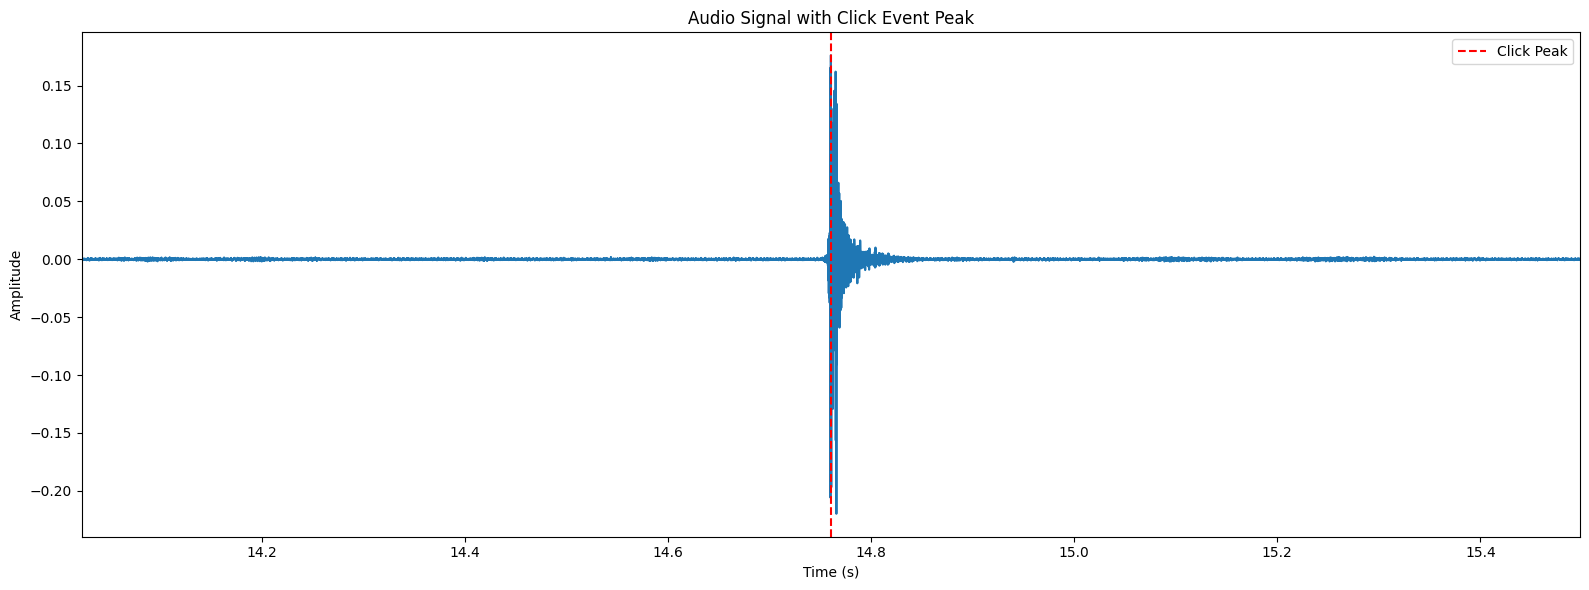

In [176]:
# plot the signal interval around the peak time of the click event for the same audio file in the selected dataset as the plot above
signal = signals[file_id_num]
time = signal_times[file_id_num]
peak_time = peak_times[file_id_num]
interval = time_interval//2

plot_signal_interval(signal, time, peak_time, interval)


### 3. Go trough the audio data with a sliding window and create training dataset
In the real-time detection a window of 0.512 seconds will be used for every chunk input at 0.128 seconds. 0.512 seconds covers 4 chunks.

In [177]:
# duration is set to be larger than click events (click events around 0.015s)

window_size_sec = 0.512 # in seconds, corresponds to 4 chunks with 2084 samples each
window_size = int(window_size_sec / resolution)
step_size_sec = 0.128 # in seconds, corresponds to a chunks with 2084 samples
step_size = int(step_size_sec / resolution)
print(window_size, step_size)

32 8


11144
11144
240
[176, 177, 178, 179, 420, 421, 422, 423, 603, 604, 605, 606, 804, 805, 806, 807, 994, 995, 996, 997, 1140, 1141, 1142, 1143, 1320, 1321, 1322, 1323, 1527, 1528, 1529, 1530, 1697, 1698, 1699, 1700, 1892, 1893, 1894, 1895, 2065, 2066, 2067, 2068, 2261, 2262, 2263, 2264, 2453, 2454, 2455, 2456, 2642, 2643, 2644, 2645, 2819, 2820, 2821, 2822, 3019, 3020, 3021, 3022, 3174, 3175, 3176, 3177, 3354, 3355, 3356, 3357, 3529, 3530, 3531, 3532, 3687, 3688, 3689, 3690, 3871, 3872, 3873, 3874, 4048, 4049, 4050, 4051, 4446, 4447, 4448, 4449, 4632, 4633, 4634, 4635, 4818, 4819, 4820, 4821, 5006, 5007, 5008, 5009, 5197, 5198, 5199, 5200, 5378, 5379, 5380, 5381, 5563, 5564, 5565, 5566, 5772, 5773, 5774, 5775, 5954, 5955, 5956, 5957, 6133, 6134, 6135, 6136, 6316, 6317, 6318, 6319, 6507, 6508, 6509, 6510, 6696, 6697, 6698, 6699, 6910, 6911, 6912, 6913, 7073, 7074, 7075, 7076, 7250, 7251, 7252, 7253, 7432, 7433, 7434, 7435, 7605, 7606, 7607, 7608, 7788, 7789, 7790, 7791, 7973, 7974, 7975, 7

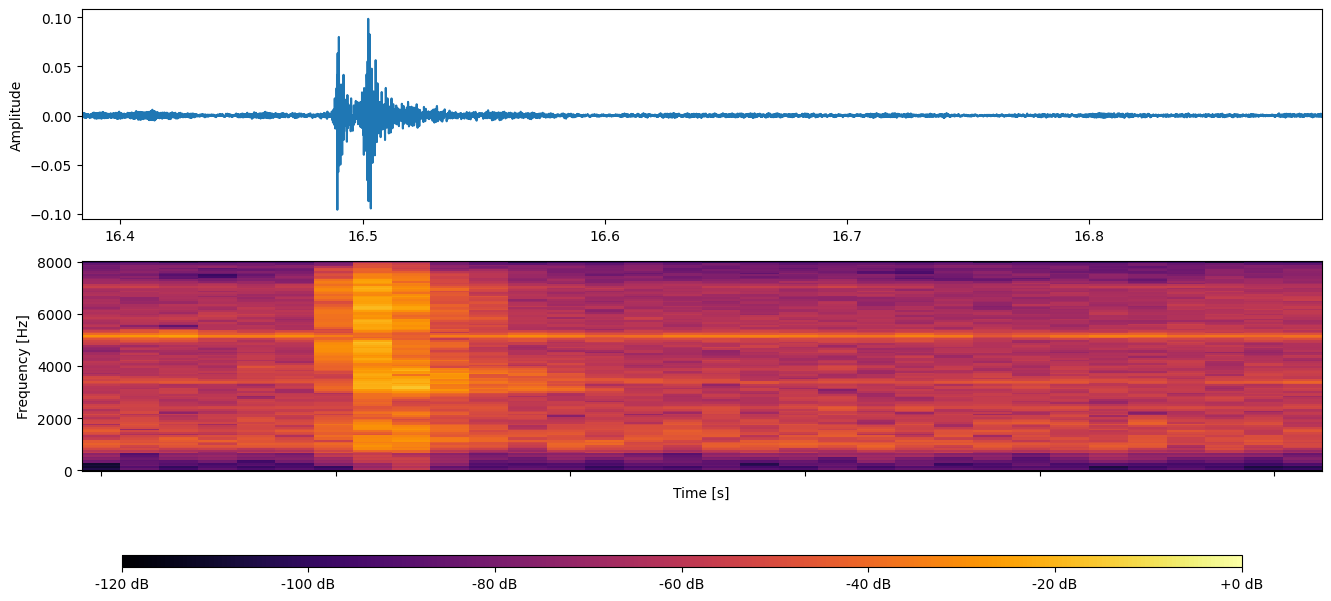

In [178]:
spec_chunk_dataset = []
spec_chunk_labels = []
signal_chunks = []
time_chunks = []

def createSpectrogramDataset(spectrograms, signals, signal_times, peak_times):
    for i in range(len(spectrograms)):
        spectrogram = spectrograms[i]
        signal = signals[i]
        time = signal_times[i]
        peak_time = peak_times[i]
        peak_time_index = int(peak_time / resolution)

        for start_idx in range(0, spectrogram.shape[1] - window_size, step_size):
            end_idx = start_idx + window_size
            
            spectrogram_chunk = spectrogram[:,start_idx:end_idx]
            signal_chunk = signal[start_idx*hop_length:end_idx*hop_length]
            time_chunk = time[start_idx*hop_length : end_idx*hop_length]
            
            if start_idx <= peak_time_index < end_idx:
                label = 1
            else:
                label = 0

            spec_chunk_dataset.append(spectrogram_chunk)
            spec_chunk_labels.append(label)
            signal_chunks.append(signal_chunk)
            time_chunks.append(time_chunk)

    return spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks

spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks = createSpectrogramDataset(spectrograms, signals, signal_times, peak_times)

print(len(spec_chunk_dataset))
print(len(spec_chunk_labels))
print(spec_chunk_labels.count(1))
print([i for i, x in enumerate(spec_chunk_labels) if x == 1])

chunk_id_to_plot = 1530
plot_mel_spectrogram(signal_chunks[chunk_id_to_plot], time_chunks[chunk_id_to_plot], spec_chunk_dataset[chunk_id_to_plot])

### 4. Save the labeled dataset to the same folder as the audio files processed in .npz format

-120.0 3.018508
(128, 32)
11144
11144
240


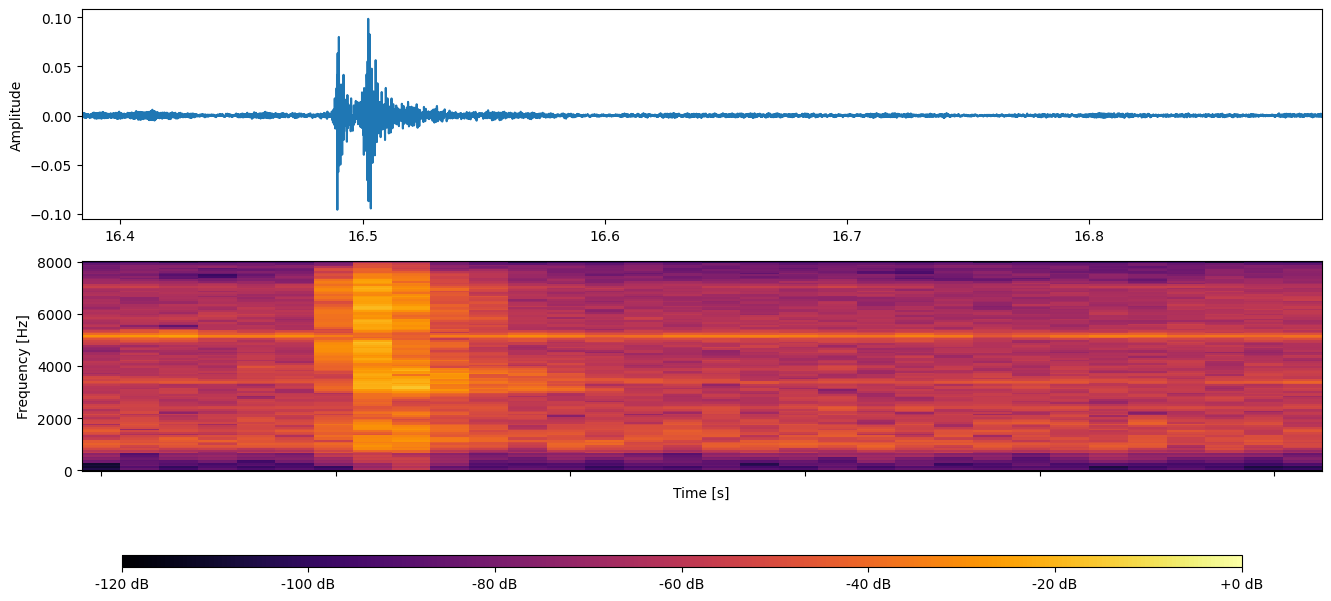

In [179]:
save_directory = audio_dataset_dir
filename = "spec_dataset_ethernet_wo_added_noise.npz"
file_fullpath = os.path.join(save_directory, filename)

spec_chunk_dataset = np.array(spec_chunk_dataset)
spec_chunk_labels = np.array(spec_chunk_labels)

print(np.min(spec_chunk_dataset), np.max(spec_chunk_dataset))

np.savez(file_fullpath, spec_chunks=spec_chunk_dataset, labels=spec_chunk_labels)

# check if the saved dataset can be loaded
data = np.load(file_fullpath)
loaded_chunks = data['spec_chunks']
loaded_labels = data['labels']

print(loaded_chunks[0].shape)
print(len(loaded_chunks))
print(len(loaded_labels))
# count the number of positive labels in numpy array
print(np.count_nonzero(loaded_labels == 1))

# plot out one spectrogram chunk
plot_mel_spectrogram(signal_chunks[chunk_id_to_plot], time_chunks[chunk_id_to_plot], loaded_chunks[chunk_id_to_plot])

